# INFO
 This JupyterNotebook provides code for the statistical analysis as performed in Hermes *et al.*, (2023): *Impact of Saharan dust outbreaks on short-range weather forecast errors in Europe*.


 This notebook is structured as follows:
1. Import libraries and define functions for data analysis
2. Check data availability and coordinate systems
3. Load data
4. Data analysis
5. Plotting section
6. Significance testing
7. Count number of cells per classification





# 1. Import libraries and define functions for data analysis

In [1]:
import xarray as xr
import os
import glob as gb
import numpy as np
import copy as cp
import pandas as pd
import pyproj
import shapefile
import shapely.ops as ops
from shapely.geometry import shape, Point, Polygon
from functools import partial
from tqdm import tqdm

In [2]:
def read_nc(ncfile, var):
    if var not in ncfile.variables:
        print('Error: Variable %s not found on file!' % var)
        exit()
        
    X = ncfile.variables[var].values
    return X


def read_MOD_CAMS(date_sel,idir):
    fnm = "fc_cams_%s%02d%02d_%02d_sfc_remap_lonlatbox.nc" % (date_sel.year,date_sel.month,date_sel.day,date_sel.hour)
    ifile = gb.glob("%s/%s" %(idir, fnm))   
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit() 
    ifile_in = xr.load_dataset(ifile[0], engine='netcdf4')
    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time = read_nc(ifile_in, 'time')
    dod = read_nc(ifile_in, 'duaod550')
    return  lat, lon, time, dod  
   

def read_MOD_ECMWF_hres(date_sel,idir, tld):
    date_sel_ld = date_sel-pd.Timedelta(tld,'h')
    fnm = "fc_hr_%s%02d%02d_%02d_sfc_lonlatbox.nc" % (date_sel_ld.year,date_sel_ld.month,date_sel_ld.day,date_sel_ld.hour)
    ifile = gb.glob("%s/%s" %(idir, fnm))
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit()         
    ifile_in = xr.load_dataset(ifile[0], engine='netcdf4')

    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time = read_nc(ifile_in, 'time')
    ssrd = read_nc(ifile_in, 'ssrd')
    tcc = read_nc(ifile_in, 'tcc')
    
    id_dateSel = np.where(time==date_sel)[0][0]
    time = time[id_dateSel:]
    ssrd = ssrd[id_dateSel:,...]
    tcc = tcc[id_dateSel:,...]
    # lat_m = np.flip(lat_m,axis=0)
    return  lat, lon, time, ssrd, tcc
  

def read_MOD_ECMWF_clbt(date_sel,idir,tld):
    date_sel_ld = date_sel-pd.Timedelta(tld,'h')
    fnm = "fc_ctt_%s%02d%02d_%02d_sfc_lonlatbox.nc" % (date_sel_ld.year,date_sel_ld.month,date_sel_ld.day,date_sel_ld.hour)
    # fnm = "fc_ctt_%s%02d%02d_%02d.nc" % (date_sel.year,date_sel.month,date_sel.day,date_sel.hour)
    ifile = gb.glob("%s/%s" %(idir, fnm))   
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit()         
    ifile_in = xr.load_dataset(ifile[0], engine='netcdf4')
    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time = read_nc(ifile_in, 'time')
    clbt = read_nc(ifile_in, 'clbt')
    
    id_dateSel = np.where(time==date_sel)[0][0]
    time = time[id_dateSel:]
    clbt = clbt[id_dateSel:,...]
    # lat_m = np.flip(lat_m,axis=0)
    return  lat, lon, time, clbt


def read_SAT_SIS(date_sel,idir):
    fnm = "SISin%s%02d%02d0000410231000101MA_F32_3hmean_asyn_align_lonlatbox.nc" % (date_sel.year,date_sel.month,date_sel.day)
    ifile = gb.glob("%s/%s" %(idir, fnm))   
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit()    
    ifile_in = xr.open_mfdataset(ifile[0], engine='netcdf4')
    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time = read_nc(ifile_in, 'time')
    sis = read_nc(ifile_in, 'SIS')

    id_dateSel = np.where(time==date_sel)[0][0]
    time = time[id_dateSel:]
    sis = sis[id_dateSel:,...]
    return  lat, lon, time, sis


def read_SAT_BT(date_sel,idir):
    fnm = "GRIDSAT-B1.%s.%02d.%02d.%02d.v02r01_irwin_cdr_F32_lonlatbox.nc" % (date_sel.year,date_sel.month,date_sel.day, date_sel.hour)
    ifile = gb.glob("%s/%s" %(idir, fnm)) 
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit()
    ifile_in = xr.open_mfdataset(ifile[0], engine='netcdf4', concat_dim='time', combine='nested')
    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time = read_nc(ifile_in, 'time')
    bt = read_nc(ifile_in, 'irwin_cdr')
    return  lat, lon, time, bt


def read_SAT_CMA(date_sel,idir):
    fnm = "CMAin%s%02d%02d%02d0000*_lonlatbox.nc" % (date_sel.year,date_sel.month,date_sel.day, date_sel.hour)
    ifile = gb.glob("%s/%s" %(idir, fnm)) 
    if not ifile:
        print('ERROR: file not available\n %s ' % fnm)
        exit()
    ifile_in = xr.open_mfdataset(ifile[0], engine='netcdf4')#, concat_dim='cases')
    lat = read_nc(ifile_in, 'lat')
    lon = read_nc(ifile_in, 'lon')
    time =read_nc(ifile_in, 'time') # this comes it numeric format %Y%m%d.f
    hours = (time[0]-np.floor(time[0]))*24
    time = pd.to_datetime(time, format='%Y%m%d') + pd.Timedelta(hours,'h')
    cma = read_nc(ifile_in, 'param7.0.3')
    return  lat, lon, time, cma


# Get mask from shapefile
def get_shapemask(ifile_sh,lat,lon):
    # get the shapes
    shapes = ifile_sh.shapes()
    # build a shapely polygon from shape
    polygon = shape(shapes[0])    
    mask = np.zeros([len(lat),len(lon)], dtype=bool) 
    for ii in range(len(lat)):
        for jj in range(len(lon)):
            point = Point(lon[jj],lat[ii])
            if polygon.contains(point) == True:
                mask[ii,jj] = True
    return mask #format: [lat,lon]


# Set array values at location ids to nan. Perform a deepcopy to avoid changing pointer values.
def set_nan(var, ids):
      var = cp.deepcopy(var)
      var[ids] = None
      return var
 
 
# Check if file exists
def check_file(idir, ifnm):
    ifile = gb.glob("%s/%s" %(idir, ifnm))
    if not ifile:
        print(ifnm)
        na=1
    else:
        na=0
    return na


# Calculate area for lonlat cells
def calc_area(lat,lon):
    lon_cell_out = np.append(lon - np.diff(lon)[0]/2 , lon[-1] + np.diff(lon)[0]/2)
    lat_cell_out = np.append(lat - np.diff(lat)[0]/2 , lat[-1] + np.diff(lat)[0]/2)
    
    area = np.zeros([len(lat),len(lon)])
    ii=0
    for jj in range(len(lat)):
        pgon = Polygon([(lon_cell_out[ii],lat_cell_out[jj]),(lon_cell_out[ii],lat_cell_out[jj+1]),(lon_cell_out[ii+1],lat_cell_out[jj+1]),(lon_cell_out[ii+1],lat_cell_out[jj])])
        geom_area = ops.transform(
            partial(
                pyproj.transform,
                pyproj.Proj(init='EPSG:4326'),
                pyproj.Proj(
                    proj='aea',
                    lat_1=pgon.bounds[1],
                    lat_2=pgon.bounds[3])),
            pgon)
        
        area[jj,:] = geom_area.area * 1e-6 # in km**2
        del pgon, geom_area
    return area


def wp(data, wt, percentiles):
          """Compute weighted percentiles.
          If the weights are equal, this is the same as normal percentiles.
          Elements of the C{data} and C{wt} arrays correspond to
          each other and must have equal length (unless C{wt} is C{None}).
   
          @param data: The data.
          @type data: A L{numpy.ndarray} array or a C{list} of numbers.
          @param wt: How important is a given piece of data.
          @type wt: C{None} or a L{numpy.ndarray} array or a C{list} of numbers.
                  All the weights must be non-negative and the sum must be
                  greater than zero.
          @param percentiles: what percentiles to use.  (Not really percentiles,
                  as the range is 0-1 rather than 0-100.)
          @type percentiles: a C{list} of numbers between 0 and 1.
          @rtype: [ C{float}, ... ]
          @return: the weighted percentiles of the data.
          """
          assert np.greater_equal(percentiles, 0.0).all(), "Percentiles less than zero"
          assert np.less_equal(percentiles, 1.0).all(), "Percentiles greater than one"
          data = np.asarray(data)
          assert len(data.shape) == 1
          if wt is None:
                  wt = np.ones(data.shape, float)
          else:
                  wt = np.asarray(wt, float)
                  assert wt.shape == data.shape
                  assert np.greater_equal(wt, 0.0).all(), "Not all weights are non-negative."
          assert len(wt.shape) == 1
          n = data.shape[0]
          assert n > 0
          i = np.argsort(data)
          sd = np.take(data, i, axis=0)
          sw = np.take(wt, i, axis=0)
          aw = np.add.accumulate(sw)
          if not aw[-1] > 0:
                  raise(ValueError, "Nonpositive weight sum")
          w = (aw-0.5*sw)/aw[-1]
          spots = np.searchsorted(w, percentiles)
          o = []
          for (s, p) in zip(spots, percentiles):
                  if s == 0:
                          o.append(sd[0])
                  elif s == n:
                          o.append(sd[n-1])
                  else:
                          f1 = (w[s] - p)/(w[s] - w[s-1])
                          f2 = (p - w[s-1])/(w[s] - w[s-1])
                          assert f1>=0 and f2>=0 and f1<=1 and f2<=1
                          assert abs(f1+f2-1.0) < 1e-6
                          o.append(sd[s-1]*f1 + sd[s]*f2)
          return o       


# Compute area weighted median from all non-NaN points per event cluster
def calc_wp_perCluster(data_var, data_area, percentile, idx):
    n_cluster = len(np.unique(idx))
    result = np.zeros(n_cluster)
    for ii in range(n_cluster):
        var = data_var[idx==ii,...]
        var = var[~np.isnan(var)]
        area = data_area[idx==ii,...]
        area = area[~np.isnan(area)]

        if np.sum(~np.isnan(var)) > 0:
            result[ii] = wp(var, area,[percentile])[0]
        else:
            result[ii] = np.nan
    return result
    

# Get index array for clustering consecutive days into events
def get_event_cluster_idx(times):
    series = pd.Series(times)
    time_diff = series.diff()

    idx = np.zeros(len(times))
    n_size = []
    cnt = 0

    for ii in range(len(times)-1):
        if time_diff[ii+1] <= pd.Timedelta(1, 'D'):
            idx[ii+1] = idx[ii]
            cnt += 1
        else:
            idx[ii+1] = idx[ii] + 1
            n_size.append(cnt + 1)
            cnt = 0
    n_size.append(cnt + 1)
    return idx, n_size


# Get all values which are not nan
def nonnan(in_array):
    out_array = in_array[~np.isnan(in_array)]
    return out_array      

        
# Check of coordinate pairs agree      
def check_coordinates(*coordinate_pairs):
    if len(coordinate_pairs) < 2:
        raise ValueError("At least two sets of coordinates are required for comparison.")

    # Check if all coordinate pairs have the same length
    lengths = [len(pair[0]) for pair in coordinate_pairs]
    if not all(length == lengths[0] for length in lengths):
        raise ValueError("Coordinate mismatch: Different number of coordinate dimensions.")

    # Check if all coordinate pairs have the same values
    values_equal = all(
        np.array_equal(pair[0], coordinate_pairs[0][0]) and
        np.array_equal(pair[1], coordinate_pairs[0][1])
        for pair in coordinate_pairs
    )

    if values_equal:
        print("Coordinates all matching.")
        return coordinate_pairs[0]
    else:
        raise ValueError("Coordinate mismatch: Coordinate values do not agree.")

# 2. Check data availability and coordinate systems

This section defines the event catalog, sets I/O paths, checks the availability of data files in the specified directories, and loads coordinates to check if all coordinates from different datasets agree in direction, spacing, and extent.

In [3]:
# Model leadtime
tld = 0

#%% ### Define event catalog ###
dates_all = ['2018-04-07' , '2018-04-08' , '2018-04-09' , '2018-04-23' , '2018-05-26' ,
                '2018-05-27' , '2018-05-28' , '2018-05-31' , '2018-06-11' , '2018-08-07' ,
                '2019-04-22' , '2019-04-23' , '2019-04-24' , '2019-06-10' , '2019-06-11' ,
                '2019-06-14' , '2019-06-15' , '2019-06-25' , '2019-06-26' , '2019-06-27' ,
                '2019-07-24' , '2019-07-25' , '2019-10-13' , '2019-10-14' , '2019-10-23' ,
                '2019-12-17' , '2019-12-18' , '2020-01-23' , '2020-05-13' , '2020-11-07' ,
                '2021-02-06' , '2021-02-07' , '2021-02-22' , '2021-02-23' , '2021-02-24' ,
                '2021-03-02' , '2021-03-03' , '2021-03-04' , '2021-04-01' , '2021-04-02' ,
                '2021-06-18' , '2021-06-19' , '2021-06-20' , '2022-03-15' , '2022-03-16' ,
                '2022-03-17' , '2022-03-18' , '2022-03-29' , '2022-03-30' ]

dates_all = np.unique(sorted(dates_all))
date_sel = pd.to_datetime(dates_all) + pd.Timedelta(12,'h') # always select 12 UTC only


print(f'Selected {len(date_sel)} dates.')

Selected 49 dates.


In [4]:
#%% ### SET PATHS ###
# Input data
root_dir = '/gws/nopw/j04/sensecdt/users/khermes/dust_outbreaks/DATA/'
idir_MOD_CAMS = root_dir  + 'MOD/CAMS/remap/lonlatbox'
idir_MOD_ECMWF = root_dir + 'MOD/ECMWF/netCDF/lonlatbox'
idir_SAT_SIS = root_dir + 'SAT/SIS/catalog/remap/lonlatbox'
idir_SAT_BT = root_dir + 'SAT/CTT/catalog/selvar/remap/lonlatbox'
idir_SAT_TCC = root_dir + 'SAT/TCC/grib/netCDF/lonlatbox'
# Shapefile
idir_sh = root_dir + 'Shapefiles/selected'
# Plot directory
plotdir = './plt'

In [5]:
# CHECK DATA AVAILABILITY
# ===========================
date_sel_tld = date_sel - pd.Timedelta(tld,'h')
id_missing = np.zeros(len(date_sel), dtype=bool)
print('MISSING FILES:')
for aa in tqdm(range(0,len(date_sel))):
    
    cnt=0
    cnt = cnt + check_file(idir_SAT_BT,"GRIDSAT-B1.%s.%02d.%02d.%02d.v02r01_irwin_cdr_F32_lonlatbox.nc" % (date_sel[aa].year,date_sel[aa].month,date_sel[aa].day, date_sel[aa].hour))
    cnt = cnt + check_file(idir_SAT_SIS,"SISin%s%02d%02d0000410231000101MA_F32_3hmean_asyn_align_lonlatbox.nc" % (date_sel[aa].year,date_sel[aa].month,date_sel[aa].day))
    cnt = cnt + check_file(idir_MOD_ECMWF,"fc_ctt_%s%02d%02d_%02d_sfc_lonlatbox.nc" % (date_sel_tld[aa].year,date_sel_tld[aa].month,date_sel_tld[aa].day,date_sel_tld[aa].hour))
    cnt = cnt + check_file(idir_MOD_ECMWF,"fc_hr_%s%02d%02d_%02d_sfc_lonlatbox.nc" % (date_sel_tld[aa].year,date_sel_tld[aa].month,date_sel_tld[aa].day,date_sel_tld[aa].hour))
    cnt = cnt + check_file(idir_MOD_CAMS,"fc_cams_%s%02d%02d_%02d_sfc_remap_lonlatbox.nc" % (date_sel[aa].year,date_sel[aa].month,date_sel[aa].day,date_sel[aa].hour))

    if cnt > 0:
        id_missing[aa]=1
del date_sel_tld

if sum(id_missing)==0:
        print("No missing files.")

# Select only dates with all data available
date_sel = date_sel[np.invert(id_missing)]

MISSING FILES:


100%|██████████| 49/49 [00:00<00:00, 849.26it/s]

No missing files.


In [6]:
# #%% CHECK COORDINATES & PREPARE SHAPEFILE
# #%% =====================================   
print('\n Reading coordinates...')

### Satellite ###
lat_bt, lon_bt, _, _ = read_SAT_BT(date_sel[0],idir_SAT_BT)
lat_sis, lon_sis, _, _ = read_SAT_SIS(date_sel[0],idir_SAT_SIS)
lat_tcc, lon_tcc, _, _ = read_SAT_CMA(date_sel[0],idir_SAT_TCC)

# ### Model ###
lat_ecmwf, lon_ecmwf, _, _, _ = read_MOD_ECMWF_hres(date_sel[0],idir_MOD_ECMWF,tld) 
lat_clbt, lon_clbt, _, _ = read_MOD_ECMWF_clbt(date_sel[0],idir_MOD_ECMWF,tld)
lat_cams, lon_cams, _, _ = read_MOD_CAMS(date_sel[0],idir_MOD_CAMS)# -- 1st: CUT lat ; 2nd: DOWNLOAD TEST FILES AND CHECK COORDINATES1111111111111111111111

# ### Check matching coordinates ###
(lat, lon) = check_coordinates((lat_bt, lon_bt),(lat_sis, lon_sis), (lat_tcc, lon_tcc),
                    (lat_ecmwf, lon_ecmwf), (lat_clbt, lon_clbt), (lat_cams, lon_cams))

print('Finished reading & checking coordinates.')


 Reading coordinates...


/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Coordinates all matching.
Finished reading & checking coordinates.


# 3. Load data

In [7]:
#%% ### ALLOCATE LISTS ###
ALL_sis      = []
ALL_aod_dust = []
ALL_tcc      = []
ALL_ssrd     = []
ALL_time     = []
ALL_tinit    = []
ALL_bt       = []
ALL_clbt     = []
ALL_tcc_sat  = []


In [8]:
# > START LOOP OVER EVENT CATALOG >
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
for ii in tqdm(range(0,len(date_sel))):
    # #%% ===========================
    # #%% READ IN DATA
    # #%% ===========================
    
    # ### Satellite ###
    _, _, time_tcc_sat, tcc_sat = read_SAT_CMA(date_sel[ii],idir_SAT_TCC)
    _, _, time_bt, bt = read_SAT_BT(date_sel[ii],idir_SAT_BT)
    _, _, time_sis, sis = read_SAT_SIS(date_sel[ii]+pd.Timedelta(0,'h'),idir_SAT_SIS)

    # ### Models ###
    _, _, time_ecmwf, ssrd, tcc = read_MOD_ECMWF_hres(date_sel[ii],idir_MOD_ECMWF,tld)
    _, _, time_clbt, clbt = read_MOD_ECMWF_clbt(date_sel[ii],idir_MOD_ECMWF,tld)
    _, _, time_cams, aod_dust = read_MOD_CAMS(date_sel[ii],idir_MOD_CAMS)


    # ===========================
    # PREPARE VARIABLES
    # ===========================
    tcc = tcc*100 # convert to comparable measure to tcc_sat
    ssrd[1:,...] = np.diff(ssrd, axis=0)/(3600*3) # convert from accumulated values to 3h mean in W m**-2

    
    # ===========================
    # SELECT EXACT TIME 
    # ===========================
    sel_tcc_sat  = tcc_sat[time_tcc_sat == date_sel[ii]][0]
    sel_bt       = bt[time_bt == date_sel[ii]][0]
    sel_sis      = sis[time_sis == (date_sel[ii] + pd.Timedelta(3,'h')),...][0]# model radiation are cumulative values, t_0 +1 (+3h) is thew first timestep with nonzero values
    sel_tcc      = tcc[time_ecmwf == (date_sel[ii] + pd.Timedelta(3,'h')),...][0]# model radiation are cumulative values, t_0 +1 (+3h) is thew first timestep with nonzero values
    sel_ssrd     = ssrd[time_ecmwf == (date_sel[ii] + pd.Timedelta(3,'h')),...][0]# model radiation are cumulative values, t_0 +1 (+3h) is thew first timestep with nonzero values
    sel_clbt     = clbt[time_clbt == date_sel[ii]][0]
    sel_aod_dust = aod_dust[time_cams == date_sel[ii],...][0]
    sel_time     = date_sel[ii]
    sel_tinit    = date_sel[ii] - pd.Timedelta(hours=tld)

    ALL_tcc_sat.append(sel_tcc_sat)
    ALL_bt.append(sel_bt)
    ALL_sis.append(sel_sis)
    ALL_tcc.append(sel_tcc)
    ALL_ssrd.append(sel_ssrd)
    ALL_clbt.append(sel_clbt)
    ALL_aod_dust.append(sel_aod_dust)
    ALL_time.append(sel_time)
    ALL_tinit.append(sel_tinit)      
    #<<<<<<<<<<<<<<<
    # END LOOP HERE

  0%|          | 0/49 [00:00<?, ?it/s]

/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
  2%|▏         | 1/49 [00:00<00:16,  2.95it/s]/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
  4%|▍         | 2/49 [00:02<00:57,  1.21s/it]/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  commo

In [9]:
# ===========================
# CREATE MASK FROM SHAPEFILE
# ===========================
print('\n Reading shapefile...')
fnm_sh  = 'DACH_BENELUX_FR_LIE_eurostat_continental_spl0,1.shx'
ifil_sh = '%s/%s' % (idir_sh, fnm_sh)
ifile_sh = shapefile.Reader(ifil_sh)

# Create mask from shapefile
mask_sf = get_shapemask(ifile_sh,lat,lon)            

print('Finished reading shapefile.')


 Reading shapefile...
Finished reading shapefile.


# 4. Data analysis

This section performs the main data analysis. We fisr define thresholds for the classification of the four cases:

- clear-sky with dust (csd)
- cloudy with dust (cld)
- clear-sky without dust (csnd)
- cloudy without dust (clnd)

We then generate logical arrays for indexing all model cells which match the respective class. We cluster consecutive days into events and compute area-weighted median errors for per case and event. Based on the distribution of median errors from all events, we compute percentiles.

In [10]:
# =================
# DATA ANALYSIS
# =================

#  THRESHOLD SETTINGS
# Cloud cover thresholds
trs_cs  = 25.   
trs_cl  = 75.
# Dust thresholds
trs_dod = np.concatenate((np.logspace(np.log10(0.01), np.log10(0.1), 50), np.linspace(0.125, 1, 36)))


# Convert to NumPy arrays
ALL_tcc_sat   = np.asarray(ALL_tcc_sat)
ALL_bt       = np.asarray(ALL_bt)
ALL_sis       = np.asarray(ALL_sis)
ALL_tcc       = np.asarray(ALL_tcc)
ALL_ssrd      = np.asarray(ALL_ssrd)
ALL_clbt      = np.asarray(ALL_clbt)
ALL_aod_dust  = np.asarray(ALL_aod_dust)
ALL_time      = np.asarray(ALL_time)
ALL_tinit     = np.asarray(ALL_tinit)


# CLASSIFICATION - via logical indexing
# sat (CMSAF):
id_cs_s =  ALL_tcc_sat == 0.0
id_cl_s =  ALL_tcc_sat == 1.0
# model: based on thresholds
id_cs_m = ALL_tcc < trs_cs
id_cl_m = ALL_tcc > trs_cl

# Combine mod & sat cloud information:
# both model and satellite cloudiness agree
id_cs_match = id_cs_m & id_cs_s
id_cl_match = id_cl_m & id_cl_s
# model no cloud where satellite with cloud and reverse, assigned to model
id_cs_mismatch = id_cs_m & id_cl_s
id_cl_mismatch = id_cl_m & id_cs_s

    # Shapefile mask
id_mask = np.repeat(mask_sf[np.newaxis, :, :], ALL_sis.shape[0], axis=0)
    
# Calculate area per cell
area = calc_area(lat, lon)
area_ext = np.repeat(area[np.newaxis, :, :],  ALL_sis.shape[0], axis=0)

# Compute event cluster index
idx_cluster, cluster_size = get_event_cluster_idx(ALL_time)

# Allocate temporary lists
dtmp_bt_csd  = []
dtmp_bt_cld  = []
dtmp_bt_csnd = []
dtmp_bt_clnd = []
dtmp_sis_csd  = []
dtmp_sis_cld  = []
dtmp_sis_csnd = []
dtmp_sis_clnd = []
dtmp_cf_m = []
dtmp_cf_s = []

/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of a

In [11]:
# Start loop over dod thresholds
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
for pp in tqdm(range(len(trs_dod))):

    # Get logical arrays for indexing cells which fulfill crieria for case selection
    id_csd = (id_cs_match & id_mask & (ALL_aod_dust  >= trs_dod[pp]))
    id_cld = (id_cl_match & id_mask & (ALL_aod_dust  >= trs_dod[pp]))
    id_csnd = (id_cs_match & id_mask & (ALL_aod_dust <  trs_dod[pp]))
    id_clnd = (id_cl_match & id_mask & (ALL_aod_dust <  trs_dod[pp]))                  
    
    # Compute BT differences and collect all cels per case
    DIF_bt = ALL_clbt - ALL_bt
    DIF_bt_csd = set_nan(DIF_bt, ~id_csd)
    DIF_bt_cld = set_nan(DIF_bt, ~id_cld)
    DIF_bt_csnd = set_nan(DIF_bt, ~id_csnd)
    DIF_bt_clnd = set_nan(DIF_bt, ~id_clnd)

    # Compute SIS ratio and collect all cels per case
    FRAC_sis = ALL_ssrd / ALL_sis
    FRAC_sis_csd = set_nan(FRAC_sis, ~id_csd)
    FRAC_sis_cld = set_nan(FRAC_sis, ~id_cld)
    FRAC_sis_csnd = set_nan(FRAC_sis, ~id_csnd)
    FRAC_sis_clnd = set_nan(FRAC_sis, ~id_clnd)

    # Compute area for each cell and case
    AREA_bt_csd  = set_nan(area_ext, np.isnan(DIF_bt_csd))
    AREA_bt_cld  = set_nan(area_ext, np.isnan(DIF_bt_cld))
    AREA_bt_csnd = set_nan(area_ext, np.isnan(DIF_bt_csnd))
    AREA_bt_clnd = set_nan(area_ext, np.isnan(DIF_bt_clnd))

    AREA_sis_csd  = set_nan(area_ext, np.isnan(FRAC_sis_csd))
    AREA_sis_cld  = set_nan(area_ext, np.isnan(FRAC_sis_cld))
    AREA_sis_csnd = set_nan(area_ext, np.isnan(FRAC_sis_csnd))
    AREA_sis_clnd = set_nan(area_ext, np.isnan(FRAC_sis_clnd))
    
    TCC_s = set_nan(ALL_tcc_sat, ~(id_mask & (ALL_aod_dust  >= trs_dod[pp])))
    TCC_m = set_nan(ALL_tcc, ~(id_mask & (ALL_aod_dust  >= trs_dod[pp])))
    
    # Compute area-weighted median per cluster of events
    wp50_clst_bt_csd = calc_wp_perCluster(DIF_bt_csd, AREA_bt_csd, 0.5, idx_cluster)
    wp50_clst_bt_cld = calc_wp_perCluster(DIF_bt_cld, AREA_bt_cld, 0.5, idx_cluster)
    wp50_clst_bt_csnd = calc_wp_perCluster(DIF_bt_csnd, AREA_bt_csnd, 0.5, idx_cluster)
    wp50_clst_bt_clnd = calc_wp_perCluster(DIF_bt_clnd, AREA_bt_clnd, 0.5, idx_cluster)

    wp50_clst_sis_csd = calc_wp_perCluster(FRAC_sis_csd, AREA_sis_csd, 0.5, idx_cluster)
    wp50_clst_sis_cld = calc_wp_perCluster(FRAC_sis_cld, AREA_sis_cld, 0.5, idx_cluster)
    wp50_clst_sis_csnd = calc_wp_perCluster(FRAC_sis_csnd, AREA_sis_csnd, 0.5, idx_cluster)
    wp50_clst_sis_clnd = calc_wp_perCluster(FRAC_sis_clnd, AREA_sis_clnd, 0.5, idx_cluster)
    
    cf_s = np.nanmedian(TCC_s, axis=(1,2))
    cf_m = np.nanmedian(TCC_m, axis=(1,2))

    dtmp_bt_csd.append(wp50_clst_bt_csd)
    dtmp_bt_cld.append(wp50_clst_bt_cld)
    dtmp_bt_csnd.append(wp50_clst_bt_csnd)
    dtmp_bt_clnd.append(wp50_clst_bt_clnd)

    dtmp_sis_csd.append(wp50_clst_sis_csd)
    dtmp_sis_cld.append(wp50_clst_sis_cld)
    dtmp_sis_csnd.append(wp50_clst_sis_csnd)
    dtmp_sis_clnd.append(wp50_clst_sis_clnd)
    
    dtmp_cf_m.append(cf_m)
    dtmp_cf_s.append(cf_s)
    # <<<<<<<<<<<<<<<<<<<<<<<<
    # end loop



  0%|          | 0/86 [00:00<?, ?it/s]/tmp/ipykernel_11530/1919184926.py:19: RuntimeWarning: divide by zero encountered in divide
  FRAC_sis = ALL_ssrd / ALL_sis
/tmp/ipykernel_11530/1919184926.py:19: RuntimeWarning: invalid value encountered in divide
  FRAC_sis = ALL_ssrd / ALL_sis
 57%|█████▋    | 49/86 [00:05<00:04,  9.02it/s]/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tmp/ipykernel_11530/1919184926.py:52: RuntimeWarning: invalid value encountered in divide
  cf_s = np.nansum(AREA_cl_s, axis=(1,2)) / np.nansum(AREA_all_s, axis=(1,2))
100%|██████████| 86/86 [00:08<00:00,  9.80it/s]


In [12]:
# Store area-weighted median values for all clusters and dod threshold in dict
data = {'trs_dod': trs_dod,
        'bt': {
            'csd': {'cluster_medians': np.array(dtmp_bt_csd)},
            'cld': {'cluster_medians': np.array(dtmp_bt_cld)},
            'csnd': {'cluster_medians': np.array(dtmp_bt_csnd)},
            'clnd': {'cluster_medians': np.array(dtmp_bt_clnd)},
            },
        'sis': {
            'csd': {'cluster_medians': np.array(dtmp_sis_csd)},
            'cld': {'cluster_medians': np.array(dtmp_sis_cld)},
            'csnd': {'cluster_medians': np.array(dtmp_sis_csnd)},
            'clnd': {'cluster_medians': np.array(dtmp_sis_clnd)},
            },
        'cf' : {
            'mod' : np.array(dtmp_cf_m),
            'sat' : np.array(dtmp_cf_s),
            }
}

# Compute percentiles from medians of clusters 
percentiles = [5, 10, 25, 50, 75, 90, 95]
cases = ['csd', 'cld', 'csnd', 'clnd']
for case in cases:
    for pct in percentiles:
        data['bt'][case][f'pct{pct}'] = np.nanpercentile(data['bt'][case]['cluster_medians'], q=pct, axis=1)
        data['sis'][case][f'pct{pct}'] = np.nanpercentile(data['sis'][case]['cluster_medians'], q=pct, axis=1)

/home/users/khermes/miniconda3/envs/dustOutbreaks/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


# 5. Plotting section

This secton loads libraries for visualisation and generates plots for analysing the sensitivity of model errors to the DOD threshold for the classification with/without dust.

We generate 3 plots:
1. BT errors for the 4 cases
2. SIS errors for the 4 cases
3. Cloud fraction in the IFS model and MSG cloud mask

In [13]:
# =================
# PLOTTING SECTION
# =================

import matplotlib.pyplot as plt
from matplotlib import gridspec#, scale
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable



# Plot quality settings
dpi_set = 600

    # create output directory for plots
odir =  ('%s' % (plotdir))
os.makedirs(odir, exist_ok = True)
os.chdir(odir)


# Prepare data for boxplots
dod_boxes = 0.1
idx_dod_boxes = np.where(trs_dod==dod_boxes)[0][0]
boxes_bt = []
boxes_sis = []  
for ii in range(len(cases)):
    case = cases[ii]
    boxes_bt.append({'label'  : case,
                    'whislo': data['bt'][case]['pct10'][idx_dod_boxes],
                    'q1'    : data['bt'][case]['pct25'][idx_dod_boxes],
                    'med'   : data['bt'][case]['pct50'][idx_dod_boxes],
                    'q3'    : data['bt'][case]['pct75'][idx_dod_boxes],
                    'whishi': data['bt'][case]['pct90'][idx_dod_boxes],
                    'fliers': []
                })
    boxes_sis.append({'label'  : case,
                    'whislo': data['sis'][case]['pct10'][idx_dod_boxes],
                    'q1'    : data['sis'][case]['pct25'][idx_dod_boxes],
                    'med'   : data['sis'][case]['pct50'][idx_dod_boxes],
                    'q3'    : data['sis'][case]['pct75'][idx_dod_boxes],
                    'whishi': data['sis'][case]['pct90'][idx_dod_boxes],
                    'fliers': []
                })


Print numeric values for both variables and all four cases, at DOD threshold as used for boxplots:

In [14]:
for var in ['bt', 'sis']:
    print(f'=== Variable: {var} ===')
    for case in ['csd', 'cld', 'csnd', 'clnd']:
        print(f'Case: {case}')

        print('Median: %f' % np.median(nonnan(data[var][case]['cluster_medians'][idx_dod_boxes])))
        print('Mean: %f' % np.mean(nonnan(data[var][case]['cluster_medians'][idx_dod_boxes])))
        print('Stddev: %f \n' % np.std(nonnan(data[var][case]['cluster_medians'][idx_dod_boxes])))


=== Variable: bt ===
Case: csd
Median: -0.849165
Mean: -1.481061
Stddev: 2.832794 

Case: cld
Median: 7.000640
Mean: 8.536398
Stddev: 9.098919 

Case: csnd
Median: -1.501331
Mean: -1.969299
Stddev: 2.233291 

Case: clnd
Median: 1.707926
Mean: 2.423034
Stddev: 4.126828 

=== Variable: sis ===
Case: csd
Median: 0.968419
Mean: 0.975458
Stddev: 0.097579 

Case: cld
Median: 1.062138
Mean: 1.140960
Stddev: 0.194472 

Case: csnd
Median: 0.945081
Mean: 0.939401
Stddev: 0.036827 

Case: clnd
Median: 1.001231
Mean: 1.059057
Stddev: 0.148547 



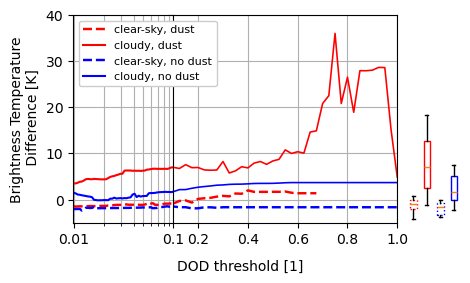

0

In [15]:
# SENSITIVITY TO DOD

# ======== BT ========
nday = 1
nbxs = 4
xpos = np.arange(0, nday*(nbxs+2))
xpos = np.delete(xpos, np.concatenate([np.arange(nbxs,nday*(nbxs+2),nbxs+2), np.arange(nbxs+1,nday*(nbxs+2),nbxs+2)]))


#  ####### PLOT ########
ylabnm = 'Brightness Temperature\n Difference [K]'

fig = plt.figure()
            
plt.rcParams["mathtext.default"] = 'regular'

fig.set_figheight(6)
fig.set_figwidth(5)             
spec = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.225, height_ratios=[1,1], width_ratios=[6,1])

axR = fig.add_subplot(spec[0,0])
axB = fig.add_subplot(spec[0,1])

lwd = 1.75 # linewidth

xmin = 0.01
xdiv = 0.1
xmax = 1.0
ymin = -5
ymax = 40
    
axR.set_xscale('linear')
axR.set_xlim((xdiv, xmax))
axR.spines['left'].set_visible(False)
axR.yaxis.set_ticks_position('left')
axR.yaxis.set_visible(True)
axR.set_xlabel('DOD threshold [1]')
axR.xaxis.set_label_coords(0.3, -0.175)
plt.setp(axR.get_yticklabels(), visible=False)
axR.set_xticks((0.2,0.4,0.6,0.8,1.0))
axR.set_xticklabels(['0.2','0.4','0.6','0.8','1.0'])
axR.set(xlim = ([xdiv, xmax]),
        ylim    = ([ymin, ymax]),
        ylabel  = (ylabnm))

divider = make_axes_locatable(axR)
axL = divider.append_axes("left", size=1.0, pad=0, sharey=axR)
axL.set_xscale('log')
axL.set_xlim((xmin-0.0001, xdiv))
axL.set_xticks((xmin,xdiv))
axL.set_xticklabels((str(xmin),str(xdiv)))
axL.set_ylabel(ylabnm)

axR.plot(trs_dod[~np.isnan(data['bt']['csd']['pct50'])], nonnan(data['bt']['csd']['pct50']), label = "clear-sky, dust", color='red',linewidth=lwd, linestyle='dashed')
axR.plot(trs_dod[~np.isnan(data['bt']['cld']['pct50'])], nonnan(data['bt']['cld']['pct50']), label = "cloudy, dust", color='red',linewidth=lwd/1.5)
axR.plot(trs_dod[~np.isnan(data['bt']['csnd']['pct50'])], nonnan(data['bt']['csnd']['pct50']), label = "clear-sky, no dust", color='blue',linewidth=lwd, linestyle='dashed')
axR.plot(trs_dod[~np.isnan(data['bt']['clnd']['pct50'])], nonnan(data['bt']['clnd']['pct50']), label = "cloudy, no dust", color='blue',linewidth=lwd/1.5)

axL.plot(trs_dod, data['bt']['csd']['pct50'],  label = "clear-sky, dust", color='red',linewidth=lwd, linestyle='dashed')
axL.plot(trs_dod, data['bt']['cld']['pct50'],  label = "cloudy, dust", color='red')
axL.plot(trs_dod, data['bt']['csnd']['pct50'], label = "clear-sky, no dust", color='blue',linewidth=lwd, linestyle='dashed')
axL.plot(trs_dod, data['bt']['clnd']['pct50'], label = "cloudy, no dust", color='blue')

axR.grid(True)
axL.grid(True)
axL.grid(True, which='minor', linestyle='-')

bp = axB.bxp(boxes_bt, positions = xpos, showfliers=False, patch_artist=True)
axB.axis('off')

colfc = np.tile(['white', 'white', 'white', 'white' ], 1)
coled = np.tile(['red', 'red', 'blue', 'blue'], 1)
            
# Set box colors
for patch, color in zip(bp['boxes'], colfc):
    patch.set_facecolor(color)
for patch, color in zip(bp['boxes'], coled):
    patch.set_edgecolor(color)

# set box linestyle
for patch, style in zip(bp['boxes'], np.tile([':','-',':','-'], 1)):
    patch.set_linestyle(style)

# Add axes labels & limits
axB.set(ylim = ([ymin, ymax]))
fig.subplots_adjust(wspace=0.05, hspace=0)

# Add legend
lg = axL.legend(loc="upper left",  facecolor='white', bbox_transform=fig.transFigure, frameon=True, fontsize=8, handlelength=2)
lg.get_frame().set_alpha(None)

onm = '%s_%s_%s_%s_%s_%s.png' % ('bt', 'hres', 'median', 'sensitivity_dust_logscale', 'allEvents', fnm_sh)
# plt.savefig(f'{onm}.pdf')  
plt.savefig(onm, dpi=dpi_set, bbox_inches = "tight")
plt.show()
os.system('convert -trim %s %s' % (onm, onm))


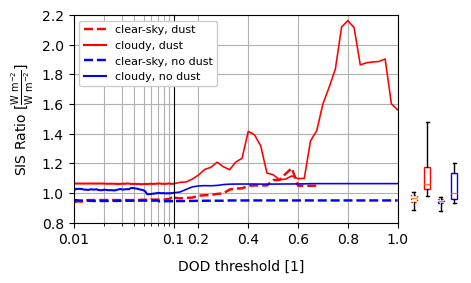

0

In [16]:
# SENSITIVITY TO DOD
# ======== SIS ========
ylabnm = r'SIS Ratio [$\frac{W\/\/m^{-2}}{W\/\/m^{-2}}$]'

# Some formatting settings
nday = 1
nbxs = 4
xpos = np.arange(0, nday*(nbxs+2))
xpos = np.delete(xpos, np.concatenate([np.arange(nbxs,nday*(nbxs+2),nbxs+2), np.arange(nbxs+1,nday*(nbxs+2),nbxs+2)]))
                
                
#   ####### PLOT ########
fig = plt.figure()
            
plt.rcParams["mathtext.default"] = 'regular'

fig.set_figheight(6)
fig.set_figwidth(5)             
spec = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.225, height_ratios=[1,1], width_ratios=[6,1])

axR = fig.add_subplot(spec[0,0])
axB = fig.add_subplot(spec[0,1])

lwd = 1.75 # linewidth

xmin = 0.01
xdiv = 0.1
xmax = 1.0
ymin = 0.8
ymax = 2.2
    
axR.set_xscale('linear')
axR.set_xlim((xdiv, xmax))
axR.spines['left'].set_visible(False)
axR.yaxis.set_ticks_position('left')
axR.yaxis.set_visible(True)
axR.set_xlabel('DOD threshold [1]')
axR.xaxis.set_label_coords(0.3, -0.175)
plt.setp(axR.get_yticklabels(), visible=False)
axR.set_xticks((0.2,0.4,0.6,0.8,1.0))
axR.set_xticklabels(['0.2','0.4','0.6','0.8','1.0'])
axR.set(xlim = ([xdiv, xmax]),
        ylim    = ([ymin, ymax]),
        ylabel  = (ylabnm))

divider = make_axes_locatable(axR)
axL = divider.append_axes("left", size=1.0, pad=0, sharey=axR)
axL.set_xscale('log')
axL.set_xlim((xmin-0.0001, xdiv))
axL.set_xticks((xmin,xdiv))
axL.set_xticklabels((str(xmin),str(xdiv)))
axL.set_ylabel(ylabnm)

axR.plot(trs_dod[~np.isnan(data['sis']['csd']['pct50'])], nonnan(data['sis']['csd']['pct50']), label = "clear-sky, dust", color='red',linewidth=lwd, linestyle='dashed')
axR.plot(trs_dod[~np.isnan(data['sis']['cld']['pct50'])], nonnan(data['sis']['cld']['pct50']), label = "cloudy, dust", color='red',linewidth=lwd/1.5)
axR.plot(trs_dod[~np.isnan(data['sis']['csnd']['pct50'])], nonnan(data['sis']['csnd']['pct50']), label = "clear-sky, no dust", color='blue',linewidth=lwd, linestyle='dashed')
axR.plot(trs_dod[~np.isnan(data['sis']['clnd']['pct50'])], nonnan(data['sis']['clnd']['pct50']), label = "cloudy, no dust", color='blue',linewidth=lwd/1.5)

axL.plot(trs_dod, data['sis']['csd']['pct50'],  label = "clear-sky, dust", color='red',linewidth=lwd, linestyle='dashed')
axL.plot(trs_dod, data['sis']['cld']['pct50'],  label = "cloudy, dust", color='red')
axL.plot(trs_dod, data['sis']['csnd']['pct50'], label = "clear-sky, no dust", color='blue',linewidth=lwd, linestyle='dashed')
axL.plot(trs_dod, data['sis']['clnd']['pct50'], label = "cloudy, no dust", color='blue')
     
axR.grid(True)
axL.grid(True)
axL.grid(True, which='minor', linestyle='-')

bp = axB.bxp(boxes_sis, positions = xpos, showfliers=False, patch_artist=True)
axB.axis('off')

colfc = np.tile(['white', 'white', 'white', 'white' ], 1)
coled = np.tile(['red', 'red', 'blue', 'blue'], 1)
            
# Set box colors
for patch, color in zip(bp['boxes'], colfc):
    patch.set_facecolor(color)
for patch, color in zip(bp['boxes'], coled):
    patch.set_edgecolor(color)

# set box linestyle
for patch, style in zip(bp['boxes'], np.tile([':','-',':','-'], 1)):
    patch.set_linestyle(style)

# Add axes labels & limits
axB.set(ylim = ([ymin, ymax]))
fig.subplots_adjust(wspace=0.05, hspace=0)

# Add legend
lg = axL.legend(loc="upper left",  facecolor='white', bbox_transform=fig.transFigure, frameon=True, fontsize=8, handlelength=2)
lg.get_frame().set_alpha(None)

onm = '%s_%s_%s_%s_%s_%s.png' % ('sis', 'hres', 'median', 'sensitivity_dust_logscale', 'allEvents', fnm_sh)
# plt.savefig(f'{onm}.pdf')  
plt.savefig(onm, dpi=dpi_set, bbox_inches = "tight")
plt.show()
os.system('convert -trim %s %s' % (onm, onm))

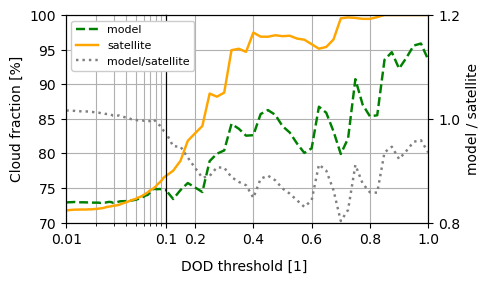

0

In [17]:
# SENSITIVITY TO DOD
# ======== Cloud cover ========

med_cf_m = np.nanmean(data['cf']['mod'], axis=1)
med_cf_s = np.nanmean(data['cf']['sat'], axis=1) *100
cf_ratio = med_cf_m / med_cf_s


#  ####### PLOT ########
ylabnm = 'Cloud fraction [%]'

fig = plt.figure()
            
plt.rcParams["mathtext.default"] = 'regular'

fig.set_figheight(6)
fig.set_figwidth(6)             
spec = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.225, height_ratios=[1,1], width_ratios=[6,1])

axR = fig.add_subplot(spec[0,0])

lwd = 1.75

xmin = 0.01
xdiv = 0.1
xmax = 1.0
ymin = 70
ymax = 100
y2min = 0.8
y2max = 1.2
    
axR.set_xscale('linear')
axR.set_xlim((xdiv, xmax))
axR.spines['left'].set_visible(False)
axR.yaxis.set_ticks_position('left')
axR.yaxis.set_visible(True)
axR.set_xlabel('DOD threshold [1]')
axR.xaxis.set_label_coords(0.3, -0.175)
# plt.setp(axR.get_yticklabels(), visible=False)
axR.set_xticks((0.2,0.4,0.6,0.8,1.0))
axR.set_xticklabels(['0.2','0.4','0.6','0.8','1.0'])
axR.set(xlim = ([xdiv, xmax]),
        ylim    = ([ymin, ymax]),
        ylabel  = (ylabnm))

divider = make_axes_locatable(axR)
axR2 = axR.twinx()
axR2.set_xscale('linear')
axR2.set_xlim((xdiv, xmax))
axR2.spines['left'].set_visible(False)
axR2.spines['right'].set_visible(True)
axR2.yaxis.set_ticks_position('right')
axR2.yaxis.set_visible(True)
axR2.set_xticks((0.2,0.4,0.6,0.8,1.0))
axR2.set_xticklabels(['0.2','0.4','0.6','0.8','1.0'])
axR2.set_xlabel('DOD threshold [1]')
axR2.set(xlim = ([xdiv, xmax]),
        ylim    = ([y2min, y2max]),
        ylabel  = ('model / satellite'))
axR2.set_yticks((0.8, 1.0, 1.2))
axR2.set_yticklabels([0.8, 1.0, 1.2])
plt.setp(axR.get_yticklabels(), visible=False)

divider2 = make_axes_locatable(axR2)
axL = divider2.append_axes("left", size=1.0, pad=0, sharey=axR)
axL.set_xscale('log')
axL.set_xlim((xmin-0.0001, xdiv))
axL.set_xticks((xmin,xdiv))
axL.set_xticklabels((str(xmin),str(xdiv)))
axL.set_ylabel(ylabnm)

axL2 = axL.twinx()
axL2.set_xscale('log')
axL2.set_xlim((xmin-0.0001, xdiv))
axL2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
axL2.set_xticks((xmin,xdiv))
axL2.set_xticklabels((str(xmin),str(xdiv)))
axL2.set(xlim = ([xmin-0.0001, xdiv]),
        ylim    = ([y2min, y2max]))

axL.plot(trs_dod, med_cf_m, label = "model", color='green',linewidth=lwd, linestyle='--')
axR.plot(trs_dod, med_cf_m, label = "model", color='green',linewidth=lwd, linestyle='--')

axL.plot(trs_dod, med_cf_s, label = "satellite", color='orange',linewidth=lwd, linestyle='solid')
axR.plot(trs_dod, med_cf_s, label = "satellite", color='orange',linewidth=lwd, linestyle='solid')

axL2.plot(trs_dod, cf_ratio, label = "satellite", color='gray',linewidth=lwd, linestyle=':')
axR2.plot(trs_dod, cf_ratio, label = "satellite", color='gray',linewidth=lwd, linestyle=':')

axR.grid(True)
axL.grid(True)
axL.grid(True, which='minor', linestyle='-')

legend = [
    Line2D([0], [0], color='green', lw=lwd, label='model', linestyle='--'),
    Line2D([0], [0], color='orange', lw=lwd, label='satellite', linestyle='solid'),
    Line2D([0], [0], color='gray', lw=lwd, label='model/satellite', linestyle=':')
]
lg = axL2.legend(handles=legend, loc='upper left', frameon=True, fontsize=8, facecolor='white')
lg.get_frame().set_alpha(None)

onm = '%s_%s_%s_%s_%s_%s.png' % ('CF', 'hres', 'mean', 'sensitivity_dust_logscale', 'allEvents', fnm_sh)
# plt.savefig(f'{onm}.pdf')  
plt.savefig(onm, dpi=dpi_set, bbox_inches = "tight")
plt.show()
os.system('convert -trim %s %s' % (onm, onm))

# 6. Significance testing

The following sections perform significance testing between the cases with dust and without dust:

In [18]:
# Function for testing the difference of distribution medians via bootstrapping
def bs_median(sample_data, n_resamples, a):
    if np.min([len(sample_data[0]), len(sample_data[1])]) == 0:
        return np.nan, np.nan
    else:
    
        dif_med = np.zeros(n_resamples)

        # Draw samples equal to the longer input
        len_rs = np.max([len(sample_data[0]), len(sample_data[1])])

        # Bootstrap resampling
        for ii in range(n_resamples):
            # Resample with replacement
            rs1 = np.random.choice(sample_data[0], len_rs, replace=True)
            rs2 = np.random.choice(sample_data[1], len_rs, replace=True)

            # Calculate the median for each resample
            dif_med[ii] = np.median(rs1) - np.median(rs2)

        dif_med = np.sort(dif_med)

        idx_CI_lo = int(n_resamples*a/2)
        idx_CI_hi = n_resamples - int(n_resamples*a/2)

        lim_CI = [dif_med[idx_CI_lo], dif_med[idx_CI_hi]]
        
        if np.sum(np.sign(lim_CI)) == 0:
            return False, lim_CI
        else:
            return True, lim_CI
    

In [19]:
# Function for testing the difference of distribution means via bootstrapping
def bs_mean(sample_data, n_resamples, a):
    if np.min([len(sample_data[0]), len(sample_data[1])]) == 0:
        return np.nan, np.nan
    else:
    
        dif_med = np.zeros(n_resamples)

        # Draw samples equal to the longer input
        len_rs = np.max([len(sample_data[0]), len(sample_data[1])])

        # Bootstrap resampling
        for ii in range(n_resamples):
            # Resample with replacement
            rs1 = np.random.choice(sample_data[0], len_rs, replace=True)
            rs2 = np.random.choice(sample_data[1], len_rs, replace=True)

            # Calculate the median for each resample
            dif_med[ii] = np.mean(rs1) - np.mean(rs2)

        dif_med = np.sort(dif_med)

        idx_CI_lo = int(n_resamples*a/2)
        idx_CI_hi = n_resamples - int(n_resamples*a/2)

        lim_CI = [dif_med[idx_CI_lo], dif_med[idx_CI_hi]]
        
        if np.sum(np.sign(lim_CI)) == 0:
            return False, lim_CI
        else:
            return True, lim_CI
    

Some settings for significance testing:

In [20]:
np.random.seed(42) # for reproducability
n_resamples = 1000 # number of bootstrap replicates
a = 0.1 # significance level
dod_testing = 0.1 # aod threshold for case classification and significance testing

idx_dod_boxes = np.where(trs_dod==dod_testing)[0][0]
print(f"Index for AOD={trs_dod[idx_dod_boxes]}: {idx_dod_boxes}")

Index for AOD=0.1: 49


Test signifinace of differences between cases with and without dust:

In [21]:
for var in ['bt', 'sis']:
        
        testdat_cs = (nonnan(data[var]['csd']['cluster_medians'][idx_dod_boxes]),
                      nonnan(data[var]['csnd']['cluster_medians'][idx_dod_boxes]))
        testdat_cl = (nonnan(data[var]['cld']['cluster_medians'][idx_dod_boxes]),
                      nonnan(data[var]['clnd']['cluster_medians'][idx_dod_boxes]))
        
        med_sg_cs, _ = bs_median(testdat_cs, n_resamples, a)
        med_sg_cl, _ = bs_median(testdat_cl, n_resamples, a)
        mean_sg_cs, _ = bs_mean(testdat_cs, n_resamples, a)
        mean_sg_cl, _ = bs_mean(testdat_cl, n_resamples, a)

        print(f'=== Variable: {var} ===')
        
        print('Median - significance dust/no dust:')
        print(f'clear-sky: {med_sg_cs}')
        print(f'cloudy: {med_sg_cl}\n')
        
        print('Mean - significance dust/no dust:')
        print(f'clear-sky: {mean_sg_cs}')
        print(f'cloudy: {mean_sg_cl}\n')

=== Variable: bt ===
Median - significance dust/no dust:
clear-sky: False
cloudy: True

Mean - significance dust/no dust:
clear-sky: False
cloudy: True

=== Variable: sis ===
Median - significance dust/no dust:
clear-sky: False
cloudy: False

Mean - significance dust/no dust:
clear-sky: True
cloudy: True



# 7. Count number of cells per classification

This section counts and prints the number of cells classified into each case or the number of cells where model and satellite agree/disagree on cloudiness.


Count cells per classified case at the chosen cloud fraction and DOD thresholds :

In [22]:
id_csd = (id_cs_match & id_mask & (ALL_aod_dust  >= trs_dod[idx_dod_boxes]))
id_cld = (id_cl_match & id_mask & (ALL_aod_dust  >= trs_dod[idx_dod_boxes]))
id_csnd = (id_cs_match & id_mask & (ALL_aod_dust <  trs_dod[idx_dod_boxes]))
id_clnd = (id_cl_match & id_mask & (ALL_aod_dust <  trs_dod[idx_dod_boxes]))  

print('=== Thresholds ===')
print(f'Clear-sky: {trs_cs}')
print(f'Cloudy: {trs_cl}')
print(f'DOD: {trs_dod[idx_dod_boxes]}\n')

print('=== Number of cells ===')
print(f'Clear-sky with dust: {np.nansum(id_csd)}')
print(f'Cloudy with dust: {np.nansum(id_cld)}')
print(f'Clear-sky w/o dust: {np.nansum(id_csnd)}')
print(f'Cloudy w/o dust: {np.nansum(id_clnd)}')


=== Thresholds ===
Clear-sky: 25.0
Cloudy: 75.0
DOD: 0.1

=== Number of cells ===
Clear-sky with dust: 4374
Cloudy with dust: 20147
Clear-sky w/o dust: 13481
Cloudy w/o dust: 30250


Count cells where model and satellite agree or disagree on cloudiness:

In [23]:
print(f"mod&sat clear-sky: {np.sum(id_cs_match&id_mask)}")
print(f"mod&sat cloudy: {np.sum(id_cl_match&id_mask)}")
print(f"mod clear-sky, sat cloudy: {np.sum(id_cs_mismatch&id_mask)}")
print(f"mod cloudy, sat clear-sky: {np.sum(id_cl_mismatch&id_mask)}")

mod&sat clear-sky: 17855
mod&sat cloudy: 50397
mod clear-sky, sat cloudy: 6166
mod cloudy, sat clear-sky: 6066
